Firstly, we need to import all necessary libraries.


#Necessary imports



In [78]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


Then, we load the file

#Code itself

In [79]:
df = pd.read_csv("creditCard.csv")
labels  = pd.read_csv("creditCardLabel.csv")


And check the first 5 rows

In [80]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


We can already see that the 1st row will cause trouble for our models, that's why we can proceed with deletion

In [81]:
df_transformation = df.copy()
df_transformation.drop(df.iloc[0].name, inplace=True)

Let's investigate the Car_owner and Propert_Owner columns

In [82]:
uniqVal = pd.concat([df['Car_Owner'], df['Propert_Owner'],]).unique()

print(uniqVal)

['Y' 'N']


As we can see, they are boolean columns, so we should make them boolean instead of string

In [83]:
df_transformation[['Car_Owner', 'Propert_Owner']] = df[['Car_Owner', 'Propert_Owner']].replace({'Y': 1, 'N': 0})


C:\Users\48515\AppData\Local\Temp\ipykernel_8392\2243219891.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformation[['Car_Owner', 'Propert_Owner']] = df[['Car_Owner', 'Propert_Owner']].replace({'Y': 1, 'N': 0})


Columns ```[Employed_years]``` and ```[Birthday_count]``` appear to be quite hard to read, let's change that.

In [84]:
# Convert Employed_days to years
df_transformation['Employed_years'] = df_transformation['Employed_days'] / 365

# Convert Birthday_count to years
df_transformation['Age'] = df_transformation['Birthday_count'] / -365

# Round the values to two decimal places
df_transformation['Employed_years'] = df_transformation['Employed_years'].round(2)
df_transformation['Age'] = df_transformation['Age'].round(2)

# Drop the original columns
df_transformation.drop(['Employed_days', 'Birthday_count'], axis=1, inplace=True)




Additionally, we can change ```[Age]``` column further, by creating age brackets

In [85]:
# Define the age brackets
age_brackets = [18, 26, 35, 46, 55, 66, 200]

# Define the labels for the age brackets
age_labels = ['18-25', '26-34', '35-45', '46-54', '55-65', '66+']

# Create a new column 'Age Bracket' based on the 'Age' column
df_transformation['Age Bracket'] = pd.cut(df_transformation['Age'], bins=age_brackets, labels=age_labels, right=False)


Perhaps, we only need to know if person is employed or not, regardless of the time employed

In [86]:
df_transformation['Is_Employed'] = (df_transformation['Employed_years'] < 0).astype(int)


Becuase collumn GENDER also consist of letters, I've decided to change the name of the column to isMale, and make it binary

In [87]:
# Convert Employed_days to years
df_transformation['isMale'] = df_transformation['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df_transformation.drop(["GENDER"],axis=1,inplace=True)

The last thing we should do is changing the categorical variables into numerical, in order to do so we will use LabelEncoding (for now)

In [88]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate over each column in the DataFrame
for column in df_transformation.columns:
    # Check if the column is of object type (categorical)
    if df_transformation[column].dtype == 'object':
        # Use label encoder to transform the column
        df_transformation[column] = label_encoder.fit_transform(df_transformation[column])



In [90]:
df

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2


In [91]:
df_transformation

,Ind_ID,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Employed_years,Age,Age Bracket,Is_Employed,isMale
1,5009744,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,-1.61,37.14,35-45,1,0
2,5009746,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,-1.61,NaN,NaN,1,0
3,5009749,1,0,0,NaN,0,1,1,1,1,1,1,0,18,2,-1.61,37.14,35-45,1,0
4,5009752,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,-1.61,37.14,35-45,1,0
5,5009753,1,0,0,315000.0,1,1,1,1,1,1,1,0,18,2,-1.61,37.14,35-45,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,0,1,0,NaN,0,1,1,1,1,0,0,0,10,2,-5.98,32.76,26-34,1,0
1544,5023655,0,0,0,225000.0,0,2,3,1,1,0,0,0,0,1,-3.31,28.02,26-34,1,0
1545,5115992,1,1,2,180000.0,3,1,1,1,1,0,0,0,10,4,-6.79,36.09,35-45,1,1
1546,5118219,1,0,0,270000.0,3,4,0,1,1,1,1,0,4,2,-1.77,41.90,35-45,1,1


Now we have two dataframes, before and after transformations, we can save both and see wich performs better on the models.

In [92]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Ind_ID,1548.0,5.078920e+06,41717.587742,5008827.0,5045069.75,5078841.5,5115673.00,5150412.0
CHILDREN,1548.0,4.127907e-01,0.776691,0.0,0.00,0.0,1.00,14.0
Annual_income,1525.0,1.913993e+05,113252.997656,33750.0,121500.00,166500.0,225000.00,1575000.0
Birthday_count,1526.0,-1.604034e+04,4229.503202,-24946.0,-19553.00,-15661.5,-12417.00,-7705.0
Employed_days,1548.0,5.936469e+04,137808.062701,-14887.0,-3174.50,-1565.0,-431.75,365243.0
Mobile_phone,1548.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
Work_Phone,1548.0,2.080103e-01,0.406015,0.0,0.00,0.0,0.00,1.0
Phone,1548.0,3.094315e-01,0.462409,0.0,0.00,0.0,1.00,1.0
EMAIL_ID,1548.0,9.237726e-02,0.289651,0.0,0.00,0.0,0.00,1.0
Family_Members,1548.0,2.161499e+00,0.947772,1.0,2.00,2.0,3.00,15.0


We can see NaN values, we need to examine the total amount and how it can impact our analysis

In [93]:
df.isna().sum()

Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
dtype: int64

There is a lot of NaN values in Type_Occupation column. We can see how much of an impact it has on our dataset by checking the total sum of all records.

In [94]:
df.count()

Ind_ID             1548
GENDER             1541
Car_Owner          1548
Propert_Owner      1548
CHILDREN           1548
Annual_income      1525
Type_Income        1548
EDUCATION          1548
Marital_status     1548
Housing_type       1548
Birthday_count     1526
Employed_days      1548
Mobile_phone       1548
Work_Phone         1548
Phone              1548
EMAIL_ID           1548
Type_Occupation    1060
Family_Members     1548
dtype: int64

In [95]:
print(488/1548)

0.3152454780361757


We can see that almost 31 % valus are missing, meaning we should take care of it. According to dataset description, column "Type_Occupation" refers to Occupation, meaning the job person is doing. We can make several approaches and then check, which performed best.


For now, we will just ignore NaN values and drop them out of df.

## Ignoring the NA's





In [96]:
df.dropna(inplace = True)

In [97]:
df.isna().sum()

Ind_ID             0
GENDER             0
Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income      0
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Birthday_count     0
Employed_days      0
Mobile_phone       0
Work_Phone         0
Phone              0
EMAIL_ID           0
Type_Occupation    0
Family_Members     0
dtype: int64

In [98]:
df_dummies =pd.get_dummies(df)
df_dummies

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
8,5010864,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,False
9,5010868,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,False
10,5010869,1,450000.0,-18173.0,-678,1,0,1,1,1,...,False,False,False,False,False,False,False,False,False,False
11,5018498,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,False
13,5018503,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,5024049,1,144000.0,-12903.0,-2924,1,0,0,0,3,...,False,False,False,False,False,False,False,False,False,False
1542,5118268,1,360000.0,-11294.0,-3536,1,0,1,0,3,...,False,False,False,False,False,False,False,False,False,False
1544,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
1545,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,False,False,True,False,False,False,False,False,False,False


Now, we can proceed with further analysis for this case. We can check the distrubutions of quantitive data

In [99]:
df_binary = df[['Phone','Work_Phone']].copy()
df_binary

,Phone,Work_Phone
8,1,0
9,1,0
10,1,0
11,1,1
13,1,1
...,...,...
1540,0,0
1542,1,0
1544,0,0
1545,0,0


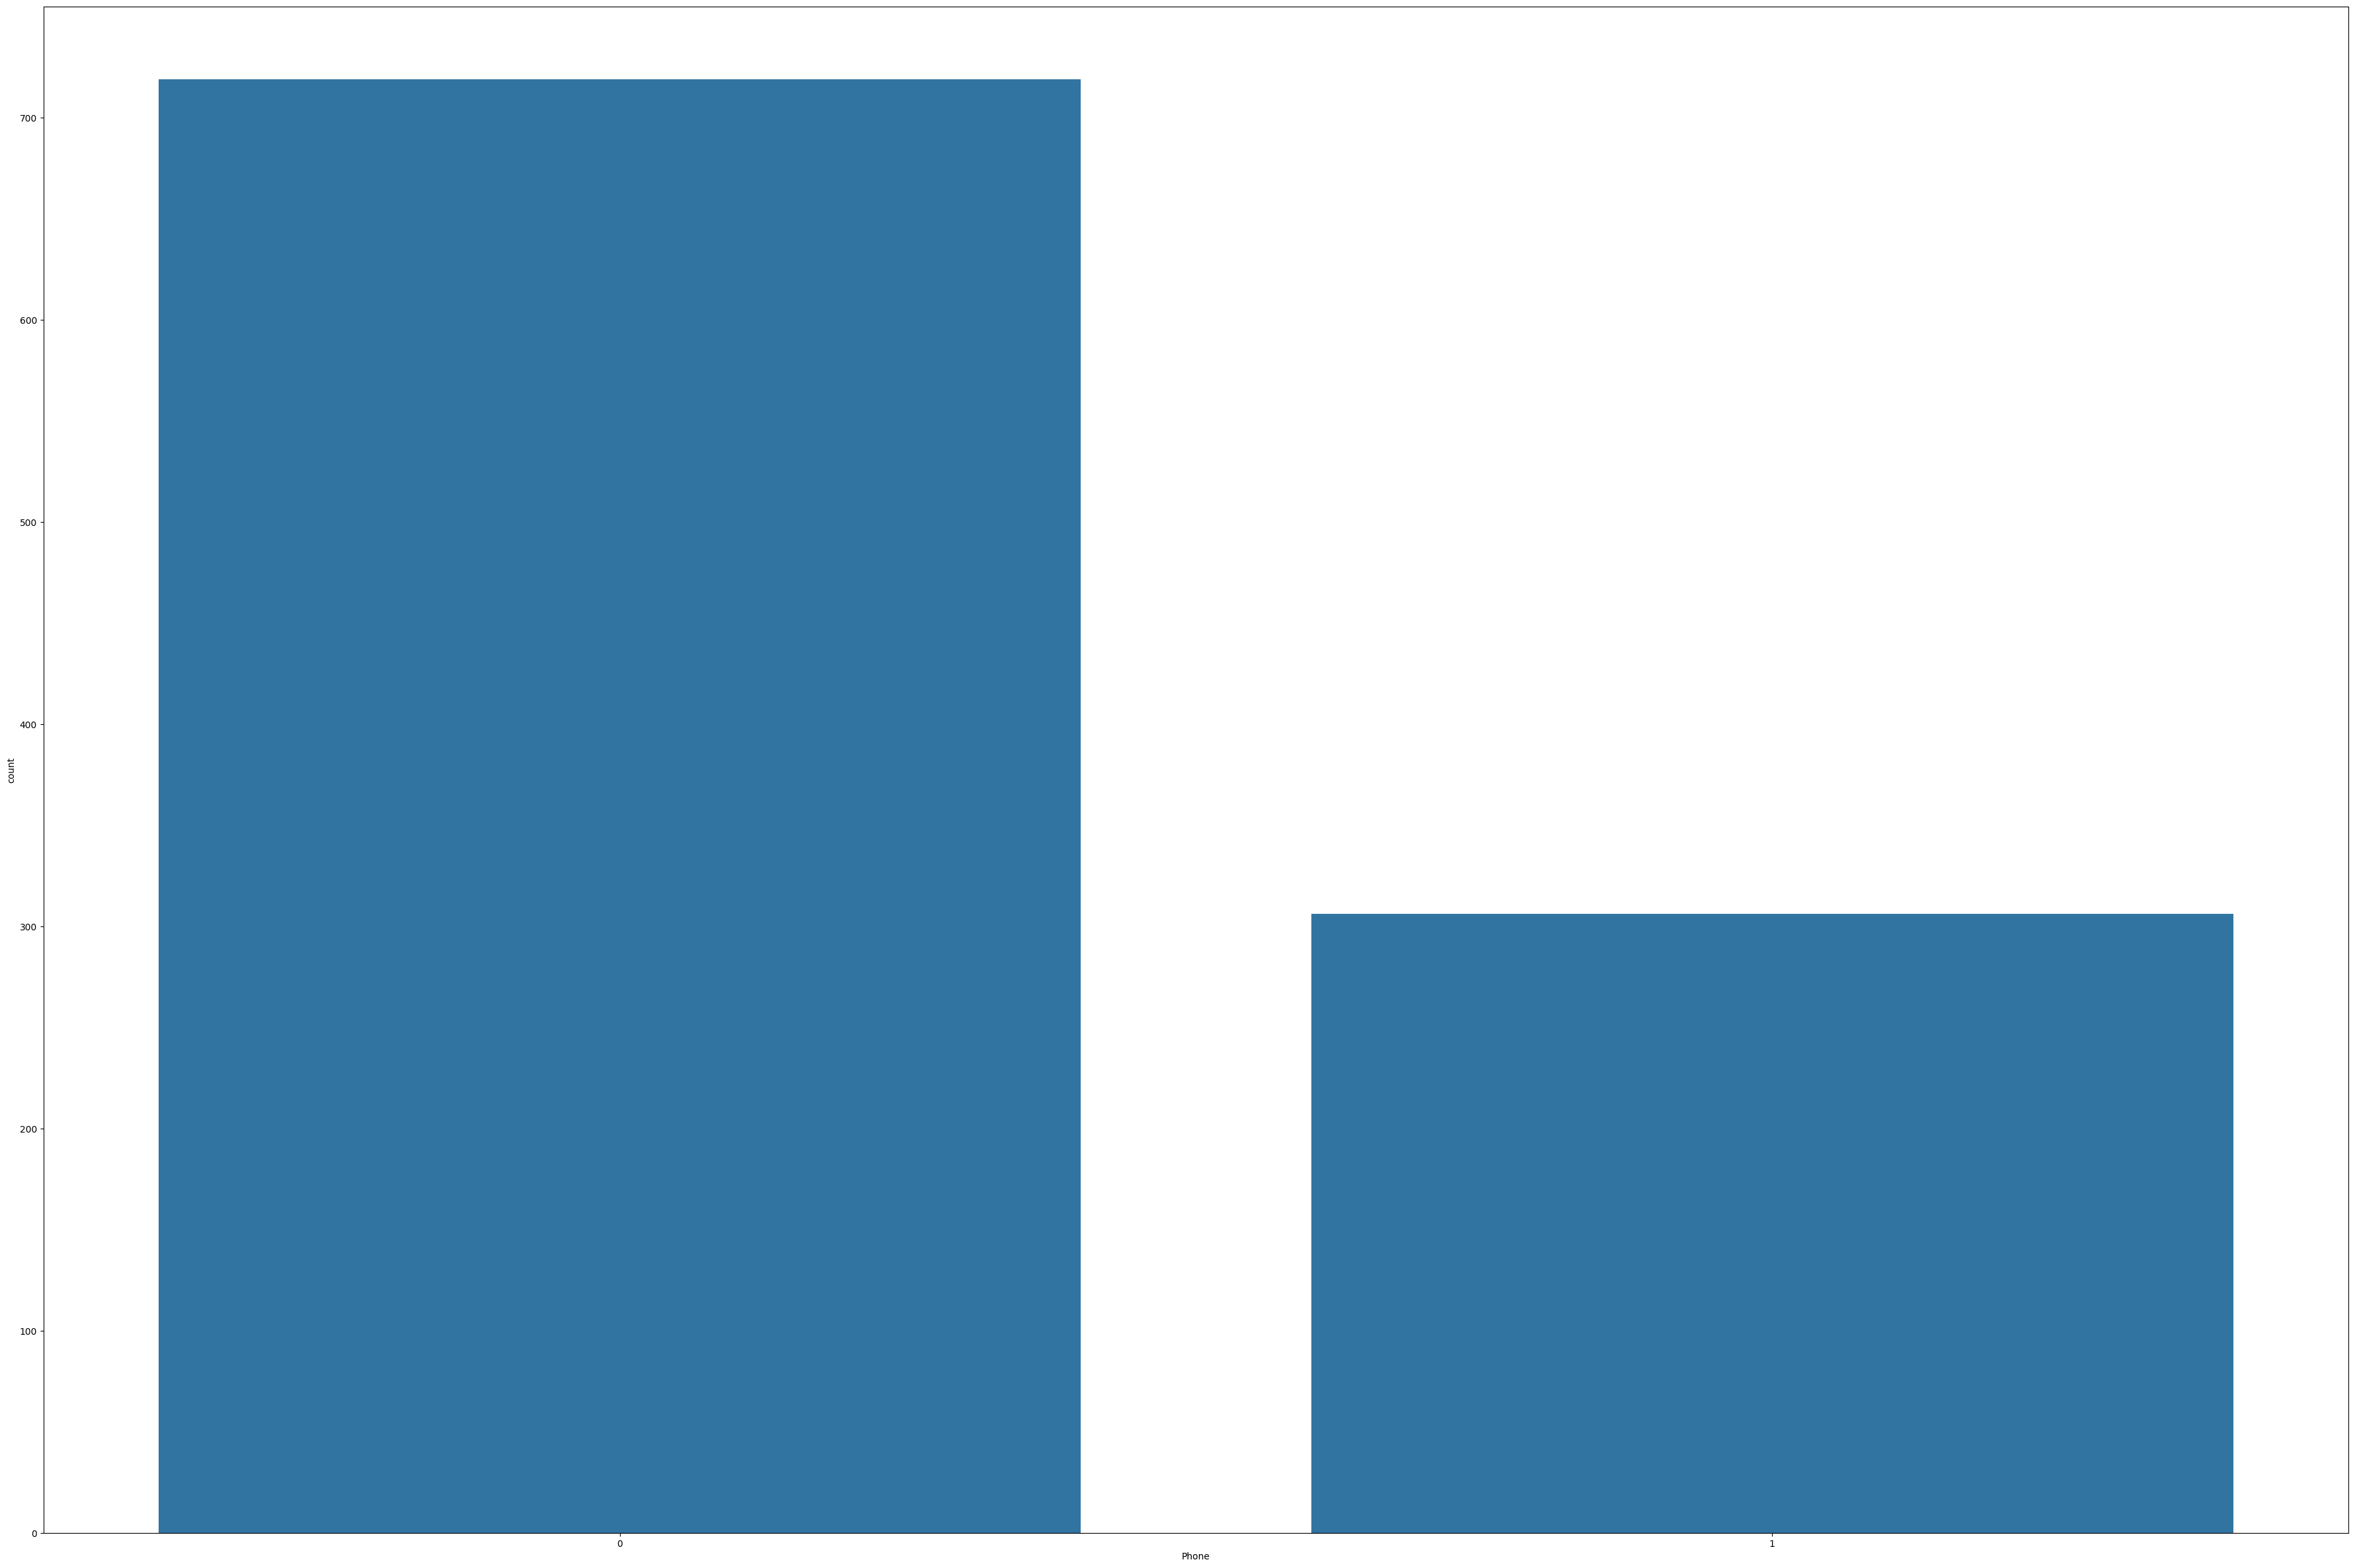

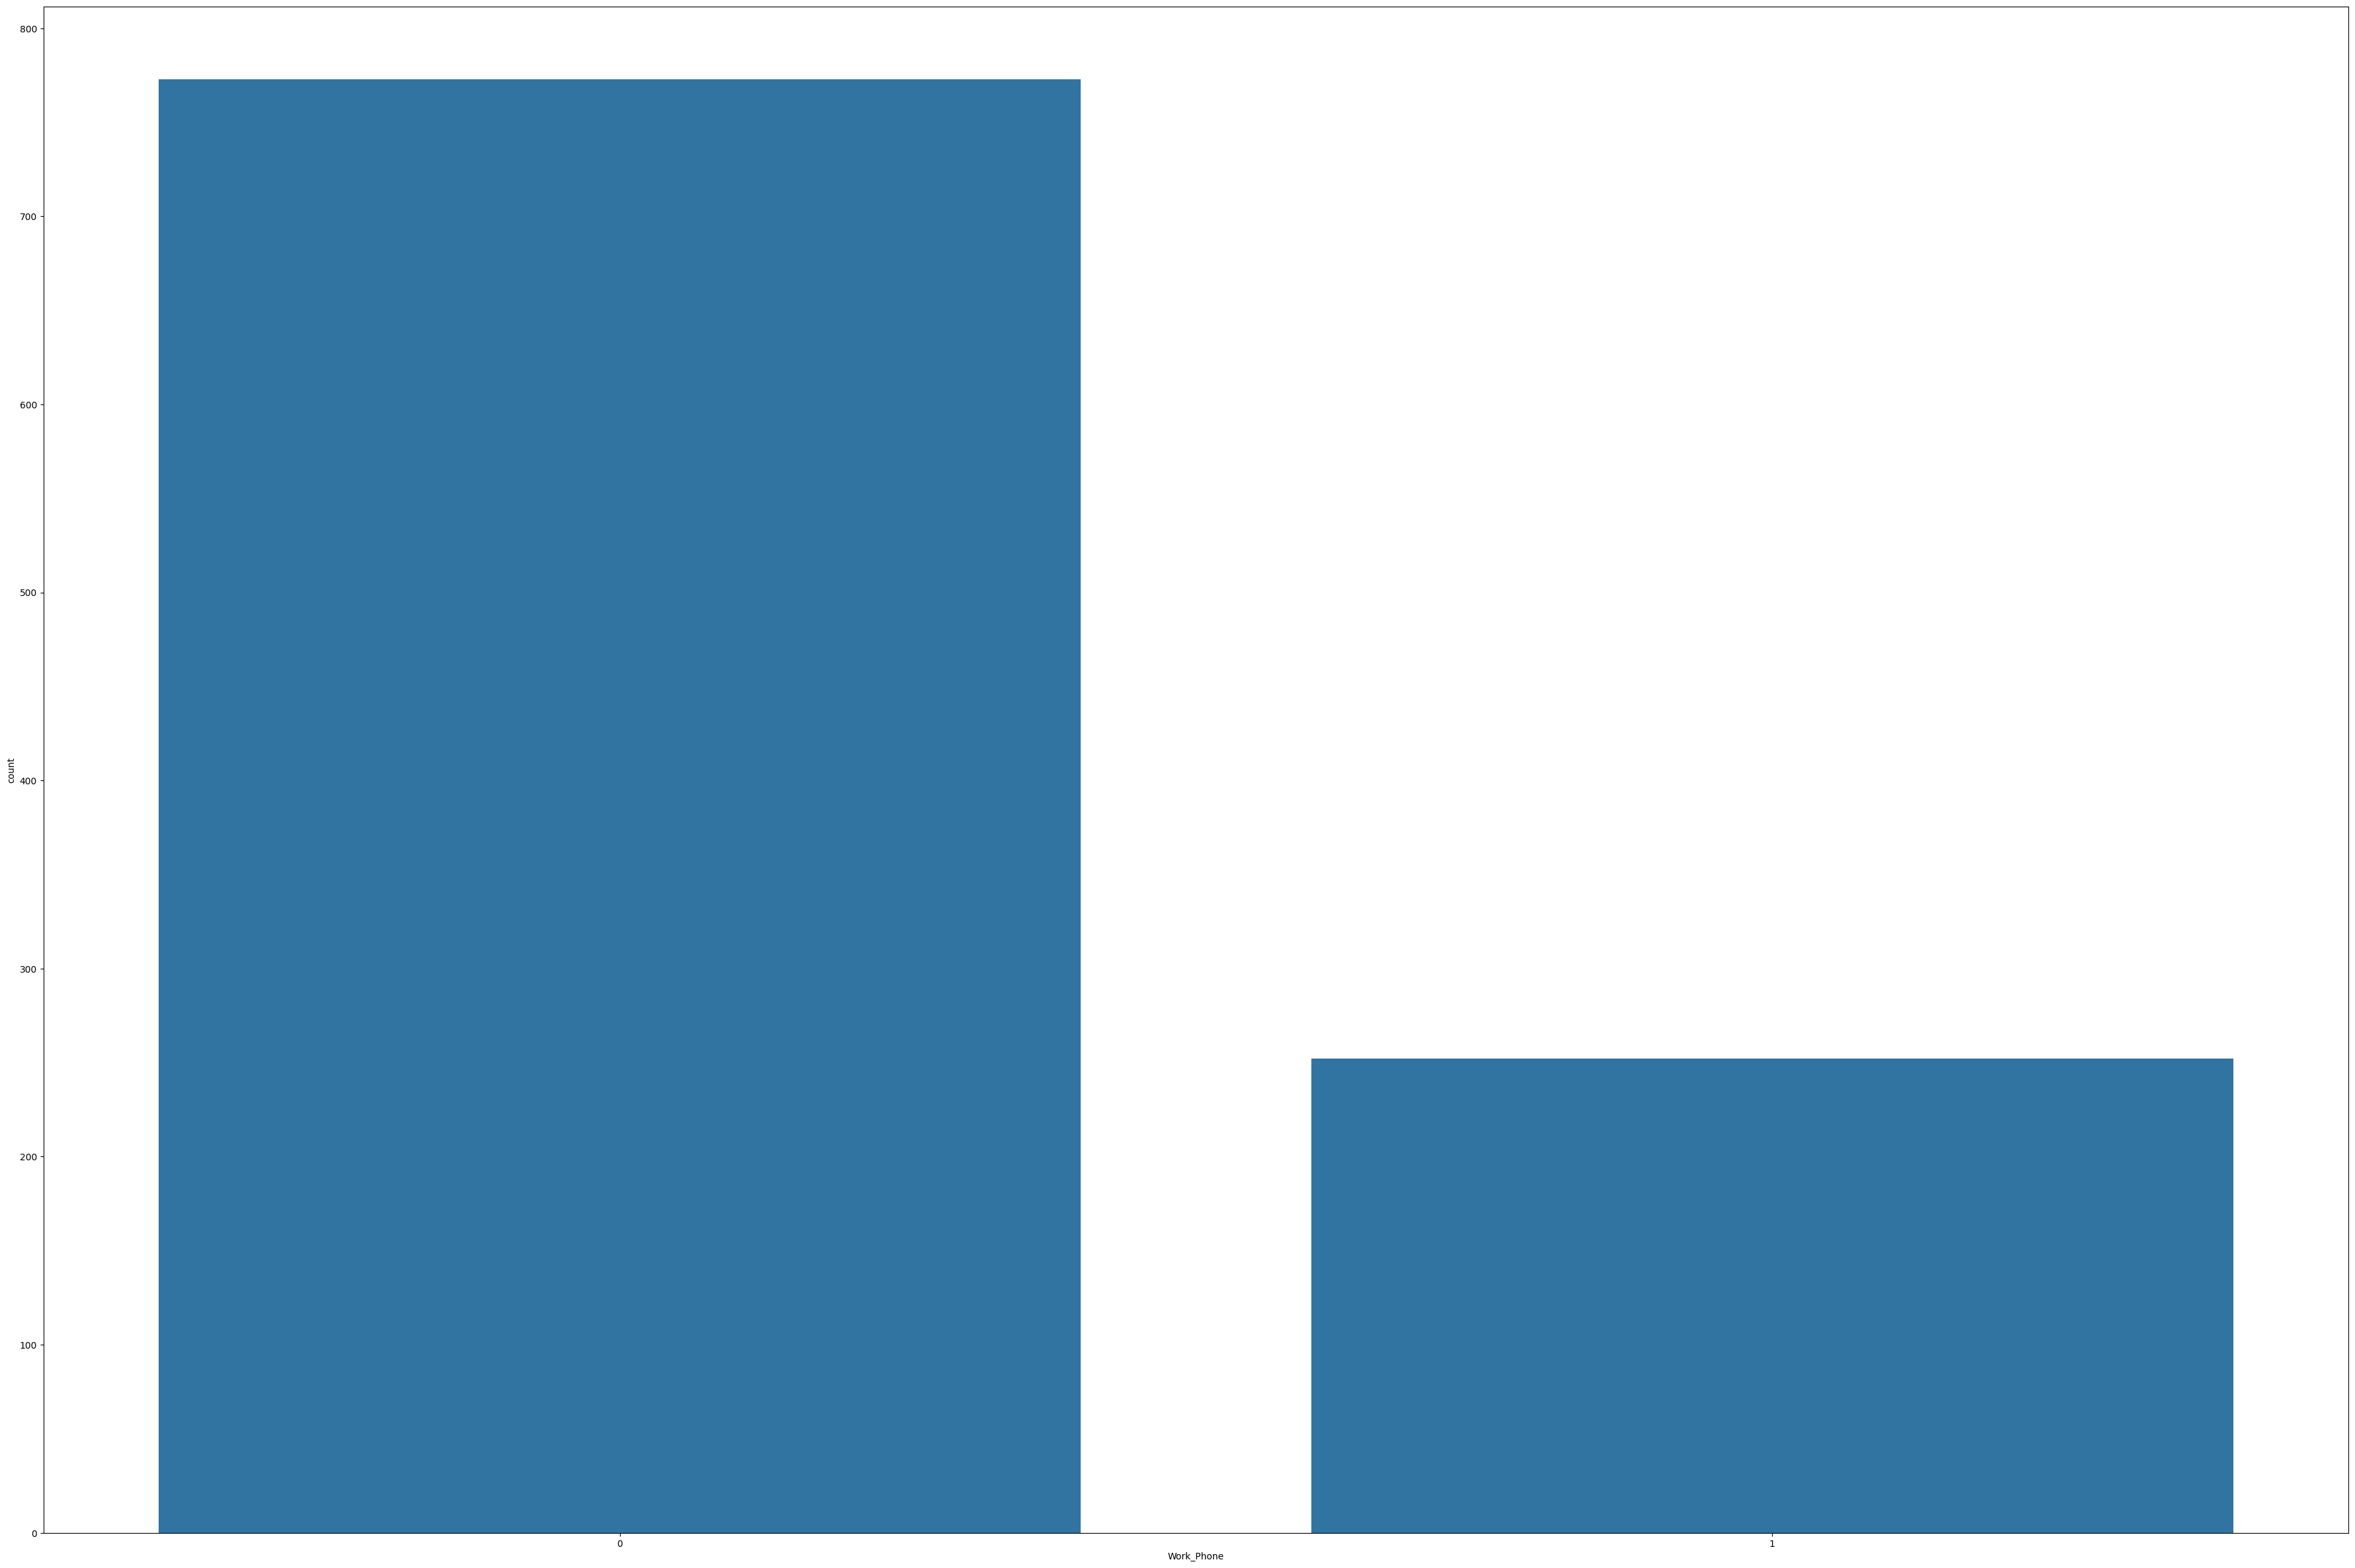

In [100]:
for i in df_binary.columns:
  plt.figure(i,figsize =[45,30] , )
  sns.countplot(data = df, x = i)

  

<Axes: >

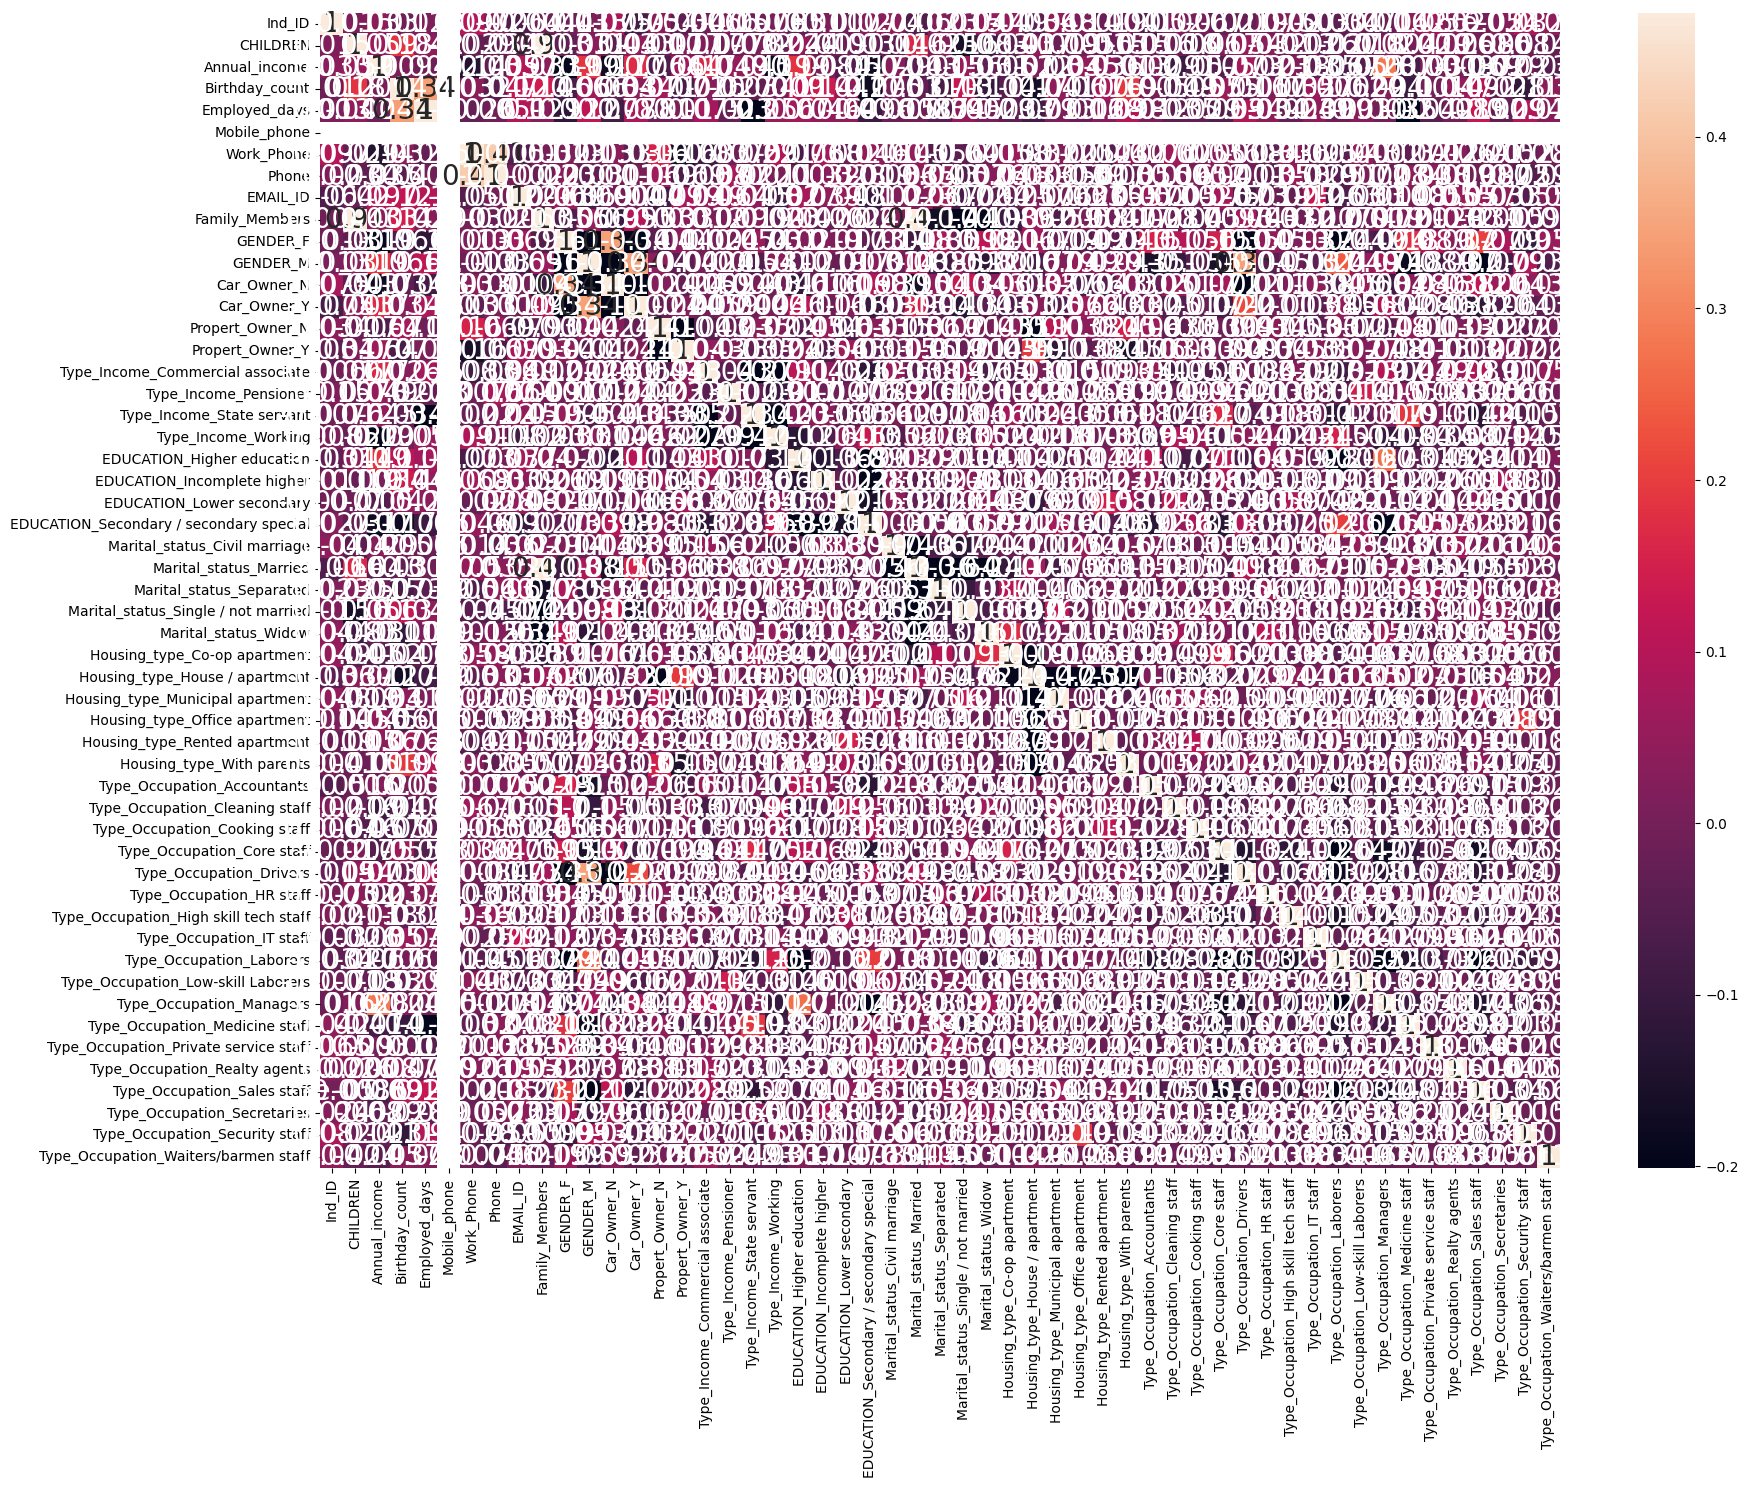

In [101]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_dummies.corr(),annot=True,robust = True,annot_kws={'size': 20})

As we can see, the correlation heatmap is not readable due to huge amount of variables. It is perfect time to conduct some feature importance/engineering techniques, such as PCA

In [102]:
df_with_labels = pd.merge(df_dummies, labels, on='Ind_ID', how='left')
df_with_labels


,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff,label
0,5010864,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,1
1,5010868,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,1
2,5010869,1,450000.0,-18173.0,-678,1,0,1,1,1,...,False,False,False,False,False,False,False,False,False,1
3,5018498,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,1
4,5018503,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5024049,1,144000.0,-12903.0,-2924,1,0,0,0,3,...,False,False,False,False,False,False,False,False,False,0
1021,5118268,1,360000.0,-11294.0,-3536,1,0,1,0,3,...,False,False,False,False,False,False,False,False,False,0
1022,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1023,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,False,True,False,False,False,False,False,False,False,0


In [103]:
X = df_with_labels.drop("label",axis = 1)
X

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
0,5010864,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,False
1,5010868,1,450000.0,-18173.0,-678,1,0,1,1,3,...,False,False,False,False,False,False,False,False,False,False
2,5010869,1,450000.0,-18173.0,-678,1,0,1,1,1,...,False,False,False,False,False,False,False,False,False,False
3,5018498,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,False
4,5018503,0,90000.0,-18950.0,-1002,1,1,1,0,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5024049,1,144000.0,-12903.0,-2924,1,0,0,0,3,...,False,False,False,False,False,False,False,False,False,False
1021,5118268,1,360000.0,-11294.0,-3536,1,0,1,0,3,...,False,False,False,False,False,False,False,False,False,False
1022,5023655,0,225000.0,-10229.0,-1209,1,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
1023,5115992,2,180000.0,-13174.0,-2477,1,0,0,0,4,...,False,False,True,False,False,False,False,False,False,False


In [104]:
y = df_with_labels['label']
y

0       1
1       1
2       1
3       1
4       1
       ..
1020    0
1021    0
1022    0
1023    0
1024    0
Name: label, Length: 1025, dtype: int64

In [105]:
model = HistGradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)


HistGradientBoostingClassifier()

In [106]:
model.score(X_test,y_test)

0.9321533923303835

In [107]:
y_pred = model.predict(X_test)

In [108]:
confusion_matrix(y_test,y_pred)

array([[294,   5],
       [ 18,  22]], dtype=int64)